# preprocess downstream dataset

In [4]:
def mol2alt_sentence_new(mol, radius):
    """Same as mol2sentence() expect it only returns the alternating sentence
    Calculates ECFP (Morgan fingerprint) and returns identifiers of substructures as 'sentence' (string).
    Returns a tuple with 1) a list with sentence for each radius and 2) a sentence with identifiers from all radii
    combined.
    NOTE: Words are ALWAYS reordered according to atom order in the input mol object.
    NOTE: Due to the way how Morgan FPs are generated, number of identifiers at each radius is smaller
    
    Parameters
    ----------
    mol : rdkit.Chem.rdchem.Mol
    radius : float 
        Fingerprint radius
    
    Returns
    -------
    list
        alternating sentence
    combined
    """
    radii = list(range(int(radius) + 1))
    info = {}
    _ = AllChem.GetMorganFingerprint(mol, radius, bitInfo=info)  # info: dictionary identifier, atom_idx, radius

    # 初始化部分
    mol_atoms = [a.GetIdx() for a in mol.GetAtoms()]
#     print(mol_atoms)
    dict_atoms = {x: {r: None for r in radii} for x in mol_atoms}
#     print(dict_atoms)
    
    for element in info:
        for atom_idx, radius_at in info[element]:
            dict_atoms[atom_idx][radius_at] = element  # {atom number: {fp radius: identifier}}
#     print(dict_atoms)
    # merge identifiers alternating radius to sentence: atom 0 radius0, atom 0 radius 1, etc.
    identifiers_alt = []
    for atom in dict_atoms:  # iterate over atoms
        for r in [radius]:  # iterate over radii
            identifiers_alt.append(dict_atoms[atom][r])
            
    alternating_sentence = map(str, [x for x in identifiers_alt]) # not ignore the null indentification
    return list(alternating_sentence)

In [5]:
def mol2alt_sentence(mol, radius):
    """Same as mol2sentence() expect it only returns the alternating sentence
    Calculates ECFP (Morgan fingerprint) and returns identifiers of substructures as 'sentence' (string).
    Returns a tuple with 1) a list with sentence for each radius and 2) a sentence with identifiers from all radii
    combined.
    NOTE: Words are ALWAYS reordered according to atom order in the input mol object.
    NOTE: Due to the way how Morgan FPs are generated, number of identifiers at each radius is smaller
    
    Parameters
    ----------
    mol : rdkit.Chem.rdchem.Mol
    radius : float 
        Fingerprint radius
    
    Returns
    -------
    list
        alternating sentence
    combined
    """
    radii = list(range(int(radius) + 1))
    info = {}
    _ = AllChem.GetMorganFingerprint(mol, radius, bitInfo=info)  # info: dictionary identifier, atom_idx, radius

    mol_atoms = [a.GetIdx() for a in mol.GetAtoms()]
    
    print(mol_atoms)
    dict_atoms = {x: {r: None for r in radii} for x in mol_atoms}

    for element in info:
        for atom_idx, radius_at in info[element]:
            dict_atoms[atom_idx][radius_at] = element  # {atom number: {fp radius: identifier}}

    # merge identifiers alternating radius to sentence: atom 0 radius0, atom 0 radius 1, etc.
    identifiers_alt = []
    for atom in dict_atoms:  # iterate over atoms
        for r in radii:  # iterate over radii
            identifiers_alt.append(dict_atoms[atom][r])

    alternating_sentence = map(str, [x for x in identifiers_alt if x])

    return list(alternating_sentence)

In [6]:
allowedAtomsDict = {
    'H' : 1,'h' : 0,
    'B' : 5,'b' : 0,
    'C' : 6,'c' : 0,
    'N' : 7,'n' : 0,
    'O' : 8,'o' : 0,
    'F' : 9,'f' : 0,
    'P' : 15,'p': 0,
    'S' : 16,'s': 0,
    'Cl': 17,'Br' : 35
}


In [7]:
word = "AaBbCcDdEeFfGgHhIiJjKkLlMmNnOoPpQqRrSsTtUuVvWwXxYyZzBrCl"
def isValidCharacter(c):
    if c not in word or (c in word and c in "HhBbCcNnOoFfPpSsClBr"):
        return True
    return False

def isValidSmiles(smiles,atom_weight = 600,heavy_atom_count = 50):
    '''
        1. smiles能够被rdkit包处理
        2. smiles只包含特定元素
        3. smiles原子权重
    '''
    t_weight = 0
    heavyAtomCount = 0
    left = -len(smiles)-1
    right = -1
    idx = -1
    while True:
        if idx <= left:
            break
        c = smiles[idx]
        if smiles[idx] == 'r' or smiles[idx] == 'l' :
            c = (smiles[idx-1] if idx -1 > right else "#") + c
            idx = idx - 1
        idx = idx - 1
        if isValidCharacter(c) == True:
            if c in allowedAtomsDict.keys():
                t_weight = t_weight + int(allowedAtomsDict[c])
                heavyAtomCount = heavyAtomCount + (1 if int(allowedAtomsDict[c]) > 1 else 0)
        else:
            return False
#     print(type(t_weight),ttype(heavy_atom_count))
    return  True if t_weight >= 3 and t_weight <= atom_weight and heavyAtomCount <= heavy_atom_count else False

In [8]:
import csv
import pandas as pd
import random
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
import matplotlib.pyplot as plt
import seaborn as sns
from mol2vec.features import mol2alt_sentence, MolSentence, DfVec, sentences2vec
from mol2vec.helpers import depict_identifier, plot_2D_vectors, IdentifierTable, mol_to_svg
import pandas as pd
from help import Help

In [9]:
path = "../dataset/pretrain/pretrain_data.txt"
total = 0
smiles = []
with open(path,"r") as f:
    for sml in f.readlines():
        if sml[-1] == "\n":
            sml = sml[:-1]
        if isValidSmiles(sml) == True:
            
            t = Chem.MolFromSmiles(sml)
            if t != None: # 能够处理
                sentence_rid_0 = mol2alt_sentence(t,0)
                sentence_rid_1 = mol2alt_sentence(t,1)
#                 print(sentence[0] == 'none')
                if sentence_rid_0[0] != None and 2*len(sentence_rid_0) != len(sentence_rid_1):
#                     print(len(sentence_rid_0),len(sentence_rid_1))
                    total += 1
                    smiles.append(sml)
                    if total >= 10:
                        break
                    
#                     smiles.append(sml)
#                     print(smiles)
print(total)

10


In [10]:
print(smiles)

['COC(=O)CCC(=O)CN.Cl', 'C[C@@H](O)[C@H]1C(=O)N2C(C(=O)O)=C(S[C@@H]3CN[C@H](Cc4c(CO)c[n+](C)n4C)C3)[C@H](C)[C@H]12.[Cl-]', 'CC(C)NCCNC(=O)CN(CC(=O)N(C)C1Cc2ccccc2C1)c1cc(Cl)ccc1Oc1ccc(Cl)cc1.Cl', 'Cc1nn(CC(=O)O)c2nc3ccccc3c(NCCCN(C)C)c12.Cl', 'COc1ccc(C(N)CCc2ccc(C)o2)cc1.Cl', 'Cc1c[nH]c2cc(/C=C/C(=O)NC3CCC(CCN4CCc5ccc(C#N)cc5CC4)CC3)ccc12.Cl', 'COc1ccccc1CN(C)CC1CC1c1cc(F)ccc1OC.Cl', 'CC(CCc1ccccc1)NCC(O)CON=C1c2ccccc2-c2ccccc21.Cl', 'COc1ccc2c(c1)CC(NCc1ccccc1)CC2.Cl', 'CNCCCNc1c2ccccc2nc2cccc([N+](=O)[O-])c12.Cl']


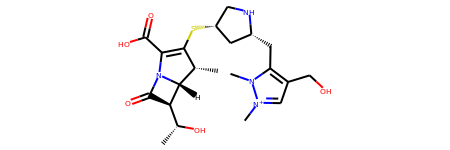

In [39]:
smiles = ['C[C@@H](O)[C@H]1C(=O)N2C(C(=O)O)=C(S[C@@H]3CN[C@H](Cc4c(CO)c[n+](C)n4C)C3)[C@H](C)[C@H]12']
aas = [Chem.MolFromSmiles(x) for x in smiles]
aas[0]

In [46]:
smiles = 'C[C@@H](O)[C@H]1C(=O)N2C(C(=O)O)=C(S[C@@H]3CN[C@H](Cc4c(CO)c[n+](C)n4C)C3)[C@H](C)[C@H]12'
mol = Chem.MolFromSmiles(smiles)
sent_0 = mol2alt_sentence(mol,0)
sent_1 = mol2alt_sentence(mol,1)
# print(sent_0)
print(sent_1[len(sent_0):])
print(len(sent_0),len(sent_1))

['1280488931', '2976033787', '321337029', '2245384272', '3599139274', '3217380708', '1803337813', '3217380708', '4089138501', '2245384272', '2849741637', '864662311', '1535166686', '3218693969', '576852318', '2092554703', '305396266', '2246728737', '3657558689', '2092489639', '78541289', '2246728737', '3657471097', '2968968094', '517457164', '2976033787', '2672648630', '2246728737', '1858577693', '2976033787', '2996859143']
31 62


In [35]:
def generate_trainAndtest_dataset(dataset_name,unactive_list,active_list):
    rate_train = 0.8
    path_output_train = "../dataset/" + dataset_name + "/raw/train.txt"
    path_output_test = "../dataset/"  + dataset_name + "/raw/test.txt"
    sepId1 = int(rate_train * len(unactive_list))
    sepId2 = int(rate_train * len(active_list))
    train = []
    test = []
    
    for sml in unactive_list[:sepId1]:
        train.append([sml,0])
    for sml in active_list[:sepId2]:
        train.append([sml,1])
    random.shuffle(train)
    
    for sml in unactive_list[sepId1:]:
        test.append([sml,0])
    for sml in active_list[sepId2:]:
        test.append([sml,1])
    random.shuffle(test)

    # 统计istrue 和 统计反true
    tt1 = 0
    tt2 = 0
    for smlAndlabel in train:
        if smlAndlabel[1] == 1:
            tt1 += 1
        else:
            tt2 += 1
    print(tt1,tt2)
    with open(path_output_train,"w") as f:
        print(path_output_train)
        for smlAndlabel in train:
#             print(smlAndlabel)
            f.write(smlAndlabel[0] + "," + str(smlAndlabel[1]) + "\n")

    with open(path_output_test,"w") as f:
        for smlAndlabel in test:
            f.write(smlAndlabel[0] + "," + str(smlAndlabel[1]) + "\n")
    return train,test

## HIV

In [6]:
path_hiv = "../dataset/hiv/raw/HIV.csv"
path_hiv_output = "../dataset/hiv/raw/processed.txt"

df = pd.read_csv(path_hiv,sep=',')
print(df)
Hiv_active = df["HIV_active"]
print('the number of HIV_active = ',sum(Hiv_active))

                                                  smiles activity  HIV_active
0      CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...       CI           0
1      C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...       CI           0
2                       CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21       CI           0
3        Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1       CI           0
4                                 O=S(=O)(O)CCS(=O)(=O)O       CI           0
...                                                  ...      ...         ...
41122  CCC1CCC2c3c([nH]c4ccc(C)cc34)C3C(=O)N(N(C)C)C(...       CI           0
41123  Cc1ccc2[nH]c3c(c2c1)C1CCC(C(C)(C)C)CC1C1C(=O)N...       CI           0
41124  Cc1ccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)C...       CI           0
41125  Cc1cccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)...       CI           0
41126  CCCCCC=C(c1cc(Cl)c(OC)c(-c2nc(C)no2)c1)c1cc(Cl...       CI           0

[41127 rows x 3 columns]
the number of HIV_active =  1443


In [10]:
# divide train and test dataset

active_list = []
unactive_list = []

smiles = df["smiles"]
state = df["HIV_active"]
# 1443 39684
for sml,state in zip(smiles,state):
    if isValidSmiles(sml) == True:
        t = Chem.MolFromSmiles(sml)
        if t != None:
            sentence = mol2alt_sentence_new(t,1)
            print(sentence[0] == 'none')
            if sentence[0] != None:
                if state == 0:
                    unactive_list.append(sml)
                else:
                    active_list.append(sml)

print(len(active_list), len(unactive_list))
# print(active_list)
# 0.8 train ，0.2 test

random.shuffle(unactive_list)
random.shuffle(active_list)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

RDKit WARNING: [09:48:34] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [09:48:34] WARNING: not removing hydrogen atom without neighbors



False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fal

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [9]:
generate_trainAndtest_dataset("hiv",unactive_list=unactive_list,active_list=active_list)

966 29872
../dataset/hiv/raw/train.txt


([['O=C(CCc1n[nH]c(=S)o1)Nc1cc(Cl)c(Cl)cc1Cl', 0],
  ['O=C(Cc1ccccc1)NN1C(=O)C(=Cc2ccc([N+](=O)[O-])cc2)SC1=Nc1ccccc1', 0],
  ['COc1ccc(C(=O)C2CCC(C(=O)O)C2)cc1', 0],
  ['CC[N+]1(CC)CCN2CCN[Co-4]213([N+](=O)[O-])[O+]=C(C)C=C(C)[OH+]3.[O-][Cl+3]([O-])([O-])O',
   0],
  ['CC1=CCOC(=O)CCC(C)=CCC1', 0],
  ['CN1C(=O)C(O)CC1c1ccc(C(F)(F)F)cc1', 0],
  ['O=C(Cn1c2ccc(Br)cc2c2nc3ccccc3nc21)NC1CCCCC1', 0],
  ['Cc1oc2c(c(C)nn2-c2ccccc2)c(=O)c1Cl', 0],
  ['O=C1C(=Cc2c[nH]c3ccccc23)C(=O)c2ccccc21', 0],
  ['O=C(O)C1(C(O)c2ccccc2)SCCCS1', 0],
  ['COc1ccc(C2SC(=N)Nc3c2c(C)nn3C(=O)c2ccncc2)cc1OC', 1],
  ['Cc1ccc2c(n1)C(N1CCCC1)=CC(=O)C2=O', 0],
  ['COC(=O)c1cc(C)ccc1C=C1Cc2c(C)cc(C)cc2C1=O', 0],
  ['COc1ccc(NCn2nc(CCCCCCCCc3nn(CNc4ccc(OC)cc4)c(=S)o3)oc2=S)cc1', 0],
  ['CC(=O)OC1CCC2C3CCC4Nc5c(cnn5-c5ccccc5)CC4(C)C3CCC12C', 0],
  ['CC(=O)N(C)c1ccc(C=C2C=Cc3ccccc32)cc1', 0],
  ['Cc1cccc(C)c1NC(=O)CCC(=O)NNC(=O)c1cc(O)c2ccccc2c1', 0],
  ['COc1ccc(C2c3cc4c(cc3OC(N3CCOCC3)C2C)OCO4)cc1OC', 0],
  ['CC1(C)OC(=

## BBBP

In [7]:
path_BBBP = "../dataset/bbbp/raw/BBBP.csv"
df = pd.read_csv(path_BBBP,sep=',')
print(df)
p_np = df["p_np"]
print('the number of HIV_active = ',sum(p_np))

       num                               name  p_np  \
0        1                         Propanolol     1   
1        2               Terbutylchlorambucil     1   
2        3                              40730     1   
3        4                                 24     1   
4        5                        cloxacillin     1   
...    ...                                ...   ...   
2045  2049                         licostinel     1   
2046  2050  ademetionine(adenosyl-methionine)     1   
2047  2051                           mesocarb     1   
2048  2052                         tofisoline     1   
2049  2053                      azidamfenicol     1   

                                                 smiles  
0                      [Cl].CC(C)NCC(O)COc1cccc2ccccc12  
1              C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl  
2     c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...  
3                      C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C  
4     Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)

In [9]:
# divide train and test dataset
active_list = []
unactive_list = []
smiles = df["smiles"]
state = df["p_np"]
# 1443 39684
for sml,state in zip(smiles,state):
    if isValidSmiles(sml) == True:
        t = Chem.MolFromSmiles(sml)
        if t != None:
            sentence = mol2alt_sentence_new(t,1)
            if sentence[0] != None:
                if state == 0:
                    unactive_list.append(sml)
                else:
                    active_list.append(sml)

print(len(active_list), len(unactive_list),len(active_list)+len(unactive_list))

random.shuffle(unactive_list)
random.shuffle(active_list)

RDKit ERROR: [12:34:09] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit WARNING: [12:34:09] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [12:34:09] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit WARNING: [12:34:09] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [12:34:09] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [12:34:09] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [12:34:09] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [12:34:09] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [12:34:09] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [12:34:09] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit WARNING: [12:34:09] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [12:34:09] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [12:34:

1550 435 1985


RDKit WARNING: [12:34:09] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [12:34:09] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [12:34:09] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [12:34:09] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [12:34:09] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [12:34:09] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [12:34:09] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [12:34:09] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [12:34:09] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [12:34:09] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [12:34:09] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [12:34:09] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [12:34:09] WARNING: not r

In [22]:
train, test = generate_trainAndtest_dataset("bbbp",unactive_list=unactive_list,active_list=active_list)

1240 348
../dataset/bbbp/raw/train.txt


In [25]:
path_output_train = "/home/linxuan/my_nlp/pretrain-gnns/chem/dataset/bbbp/raw/train.txt"
path_output_test = "/home/linxuan/my_nlp/pretrain-gnns/chem/dataset/bbbp/raw/test.txt"
with open(path_output_train,"w") as f:
    print(path_output_train)
    for smlAndlabel in train:
#             print(smlAndlabel)
        f.write(smlAndlabel[0] + "," + str(smlAndlabel[1]) + "\n")

with open(path_output_test,"w") as f:
    for smlAndlabel in test:
        f.write(smlAndlabel[0] + "," + str(smlAndlabel[1]) + "\n")


/home/linxuan/my_nlp/pretrain-gnns/chem/dataset/bbbp/raw/train.txt


## bace

In [28]:
path_bace = "../dataset/bace/raw/bace.csv"
df = pd.read_csv(path_BBBP,sep=',')
print(df)

                                                    mol        CID  Class  \
0     O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2c...     BACE_1      1   
1     Fc1cc(cc(F)c1)C[C@H](NC(=O)[C@@H](N1CC[C@](NC(...     BACE_2      1   
2     S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...     BACE_3      1   
3     S1(=O)(=O)C[C@@H](Cc2cc(O[C@H](COCC)C(F)(F)F)c...     BACE_4      1   
4     S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...     BACE_5      1   
...                                                 ...        ...    ...   
1508          Clc1cc2nc(n(c2cc1)C(CC(=O)NCC1CCOCC1)CC)N  BACE_1543      0   
1509          Clc1cc2nc(n(c2cc1)C(CC(=O)NCc1ncccc1)CC)N  BACE_1544      0   
1510             Brc1cc(ccc1)C1CC1C=1N=C(N)N(C)C(=O)C=1  BACE_1545      0   
1511       O=C1N(C)C(=NC(=C1)C1CC1c1cc(ccc1)-c1ccccc1)N  BACE_1546      0   
1512                Clc1cc2nc(n(c2cc1)CCCC(=O)NCC1CC1)N  BACE_1547      0   

      Model     pIC50         MW   AlogP  HBA  HBD  RB  ...  PEOE6 (PEOE6) 

In [29]:
# divide train and test dataset
active_list = []
unactive_list = []
smiles = df["mol"]
state = df["Class"]
# 1443 39684
for sml,state in zip(smiles,state):
    if isValidSmiles(sml) == True:
        t = Chem.MolFromSmiles(sml)
        if t != None:
            sentence = mol2alt_sentence_new(t,1)
            if sentence[0] != None:
                if state == 0:
                    unactive_list.append(sml)
                else:
                    active_list.append(sml)

print(len(active_list), len(unactive_list),len(active_list)+len(unactive_list))

random.shuffle(unactive_list)
random.shuffle(active_list)

685 817 1502


In [37]:
train,test = generate_trainAndtest_dataset(dataset_name="bace",unactive_list=unactive_list,active_list=active_list)
print(len(train),len(test))

548 653
../dataset/bace/raw/train.txt
1201 301


In [38]:
path_output_train = "/home/linxuan/my_nlp/pretrain-gnns/chem/dataset/bace/raw/train.txt"
path_output_test = "/home/linxuan/my_nlp/pretrain-gnns/chem/dataset/bace/raw/test.txt"
with open(path_output_train,"w") as f:
    print(path_output_train)
    for smlAndlabel in train:
#             print(smlAndlabel)
        f.write(smlAndlabel[0] + "," + str(smlAndlabel[1]) + "\n")

with open(path_output_test,"w") as f:
    for smlAndlabel in test:
        f.write(smlAndlabel[0] + "," + str(smlAndlabel[1]) + "\n")

/home/linxuan/my_nlp/pretrain-gnns/chem/dataset/bace/raw/train.txt
